# Mineral segmentation
*Jordan Lubbers*

## Motivation
This notebook outlines how to take a series of CT images that represent a 3D volume and segment them using the watershed algorithm. In brief the pipeline is as follows:
1. Import data. 
   - .tif, .png, or .jpg images
   - downsample the data if required
2. Rescale and normalize data so that pixel values are between 0 and 1
3. Denoise the data
   - allows for easier phase identification in histograms
4. Create an elevation map of the image using image gradient algorithms
   - accepts all methods found in scikit-image: 'sobel', 'roberts', 'scharr', 'prewitt'
5. Choose marker values as starting points for the watershed segmentation algorithm
6. Run the watershed segmentation algorithm
7. Export data
   - image stack (e.g., .png, .tif, .npy)
   - segmentation metadata (i.e., all user decisions) for reproducibility
   
This notebook utilizes the module ```ctpy``` to accomplish the above tasks. For a "from scratch" version please see the ```mineral_segmentation_fromscratch.ipynb``` notebook
   
## Import dependencies

In [6]:
import ctpy as ct
import numpy as np
import matplotlib.pyplot as plt

## Import data
Here we will import and also downsample our data so that it is more manageable on a standard personal computer

In [144]:
# path to the folder where your 2D images reside
filepath = r"D:\Jorgenson_CT_work\0053_19CJ13_xL1\stacks"

# For figure labeling and saving purposes
name = "0053_19CJ13_xL1"

stack, original_stack_shape = ct.import_stack(filepath, "tif", name, downsample=2)
stack_1D = stack.flatten()

Importing images


  0%|          | 0/390 [00:00<?, ?files/s]

downsampling images


  0%|          | 0/390 [00:00<?, ?images/s]

your original stack dimensions are (390, 994, 864)
your downsampled stack dimensions are (195, 497, 432)


## Rescale the stack
Looking at our histogram we can see that there are a very small amount of pixels with values at the far high end of the attenuation range. Because these pixels encompass negligible proportions of our data we are going to remove them to better fill the normalized range. This is known as contrast stretching and should allow us to see subtleties in our data better. We normalize the data because Python's ```sckit-image``` processing functions tend to work better with values between 0 and 1. 

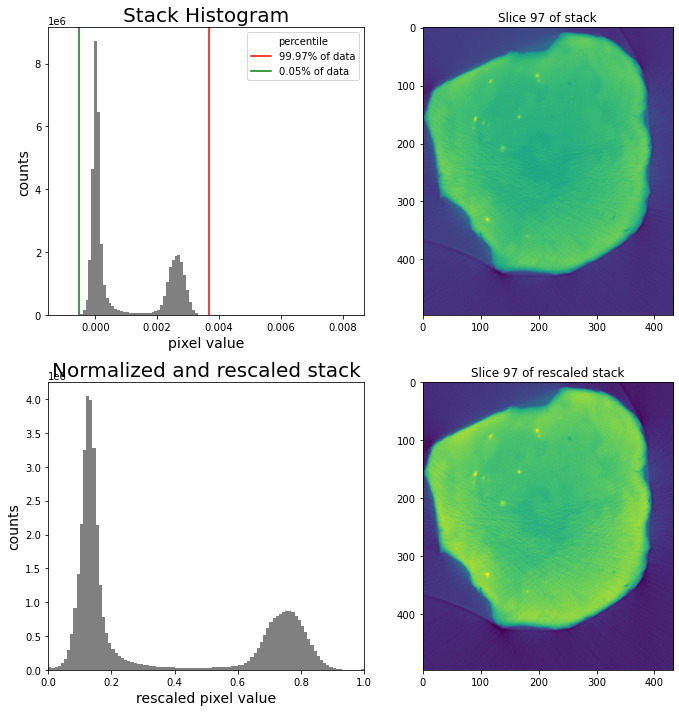

In [148]:
lower_lim, upper_lim = 0.05, 99.97
plow, phigh, stack_normal, stack_normal_1D = ct.rescale_stack(lower_lim, upper_lim, stack)


# plot up the comparison between original stack and rescaled stack
cmap = "viridis"
scale = "linear"

#halfway through the stack
slice_number = stack.shape[0] // 2

fig, ax, = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].hist(stack_1D, bins=100, color="gray")
ax[0, 0].set_title("Stack Histogram", fontsize=20)
ax[0, 0].set_yscale(scale)
ax[0, 0].axvline(phigh, c="r", label="{}% of data".format(upper_lim))
ax[0, 0].axvline(plow, c="g", label="{}% of data".format(lower_lim))
ax[0, 0].legend(loc="best", title="percentile")
ax[0, 0].set_ylabel("counts", fontsize=14)
ax[0, 0].set_xlabel("pixel value", fontsize=14)

# show the first image of the stack
ax[0, 1].imshow(stack[slice_number], cmap=cmap)
ax[0, 1].set_title("Slice {} of stack".format(slice_number))

# rescaled data

ax[1, 0].hist(stack_normal_1D, bins=100, color="gray")
ax[1, 0].set_yscale(scale)
ax[1, 0].set_ylabel("counts", fontsize=14)
ax[1, 0].set_xlabel("rescaled pixel value", fontsize=14)
ax[1, 0].set_title("Normalized and rescaled stack", fontsize=20)
ax[1, 0].set_xlim(0, 1)
# show the first image of the stack
ax[1, 1].imshow(stack_normal[slice_number], cmap=cmap)
ax[1, 1].set_title("Slice {} of rescaled stack".format(slice_number))
fig.tight_layout()

## Inspect stack

Text(0.5, 0.92, 'Rescaled stack at 10 slice increments')

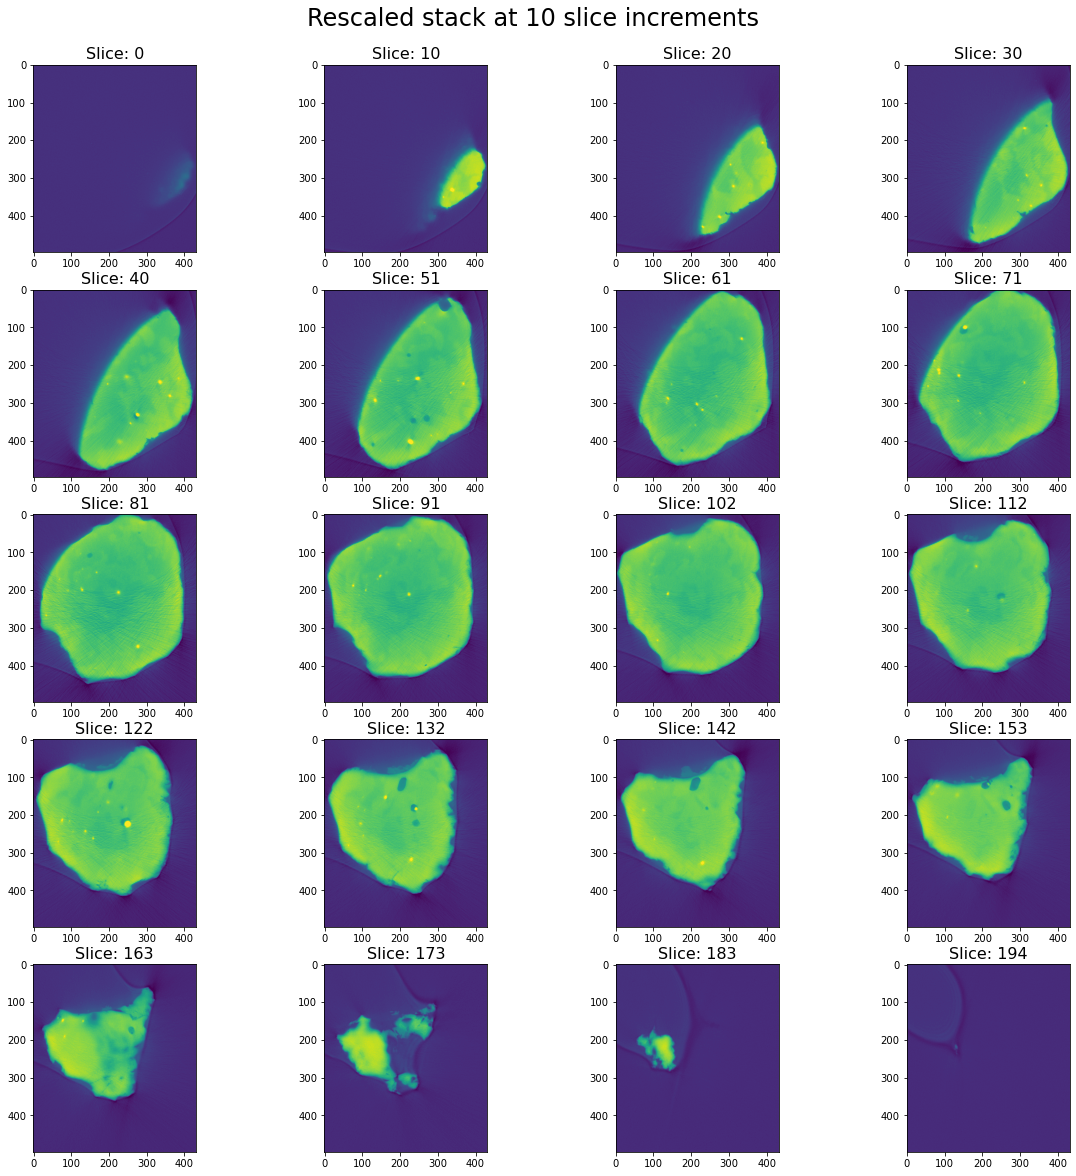

In [149]:
fig, ax = plt.subplots(5, 4, figsize=(20, 20))
axes = ax.ravel()

for i, a in zip(np.linspace(1, stack.shape[0], 20), axes):
    a.imshow(stack_normal[int(i - 1), :, :], vmin=0, vmax=1)
    a.set_title("Slice: {}".format(int(i - 1)), fontsize=16)
fig.suptitle(
    "Rescaled stack at {} slice increments".format(
        int(
            np.linspace(1, stack.shape[0], 20)[1]
            - np.linspace(1, stack.shape[0], 20)[0]
        )
    ),
    fontsize=24,
    y=0.92,
)

## Refine histogram peaks with non-local means denoising
Denoising the stack with the non-local means algorithm allows for image noise to be removed while still preserving crucial textural information. This noise removal also allows for unique phases (i.e., histogram peaks) to be identified

In [150]:
# call the non local means denoising helper function
# and specify the patch size and distance
patch_size = 5
patch_distance = 5
stack_nlm, stack_nlm_1D = ct.denoise_stack(stack_normal, patch_size, patch_distance)

  0%|          | 0/195 [00:00<?, ?it/s]

Your stack has been smoothed using the Skimage non-local means algorithm
patch size: 5
patch distance: 5


### Compare pre and post denoised slice

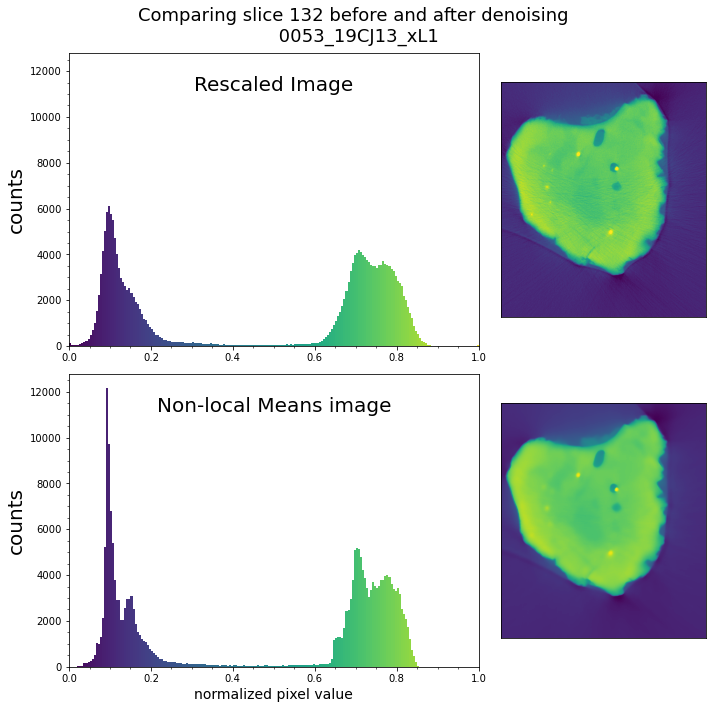

In [151]:
colormap = plt.get_cmap(cmap)
slice_nlm_1D = stack_nlm[slice_number].flatten()
slice_1D = stack_normal[slice_number].flatten()
slice_number = 132
bins = 200

fig, ax = plt.subplots(2, 2, figsize=(10, 10), gridspec_kw={"width_ratios": [2, 1],})
fig.suptitle(
    "Comparing slice {} before and after denoising \n {}".format(slice_number, name),
    fontsize=18,
)

# Histogram for rescaled image
counts, bins, patches = ax[0, 0].hist(slice_1D, bins=bins,)
ax[0, 0].minorticks_on()
ax[0, 0].set_xlim(0, 1)
ax[0, 0].set_ylabel("counts", fontsize=20)
ax[0, 0].set_title("Rescaled Image", fontsize=20, y=0.85)

# get the value for center of bins
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# color the histogram by value
for c, p in zip(bin_centers, patches):
    plt.setp(p, "facecolor", colormap(c))

# rescaled image
ax[0, 1].imshow(stack_normal[slice_number], cmap=cmap)
ax[0, 1].axes.yaxis.set_ticklabels([])
ax[0, 1].axes.yaxis.set_ticks([])
ax[0, 1].axes.xaxis.set_ticklabels([])
ax[0, 1].axes.xaxis.set_ticks([])

# Histogram for non local means image
counts2, bins2, patches2, = ax[1, 0].hist(slice_nlm_1D, bins=bins,)

# get value for center of bins
bin_centers2 = 0.5 * (bins[:-1] + bins[1:])

# color the histogram by value
for c, p in zip(bin_centers2, patches2):
    plt.setp(p, "facecolor", colormap(c))
ax[1, 0].minorticks_on()
ax[1, 0].set_ylim(0, 1.05 * np.max(counts2))

ax[1, 0].set_xlim(0, 1)
ax[1, 0].set_xlabel("normalized pixel value", fontsize=14)
ax[1, 0].set_title("Non-local Means image", fontsize=20, y=0.85)
ax[1, 0].set_ylabel("counts", fontsize=20)


# non local means image
ax[1, 1].imshow(stack_nlm[slice_number], cmap=cmap)
ax[1, 1].axes.yaxis.set_ticklabels([])
ax[1, 1].axes.yaxis.set_ticks([])
ax[1, 1].axes.xaxis.set_ticklabels([])
ax[1, 1].axes.xaxis.set_ticks([])
ax[1, 0].set_ylim(0, 1.05 * np.max(counts2))
ax[0, 0].set_ylim(0, 1.05 * np.max(counts2))
fig.tight_layout()

### Compare pre and post denoised stack

(0.0, 1.0)

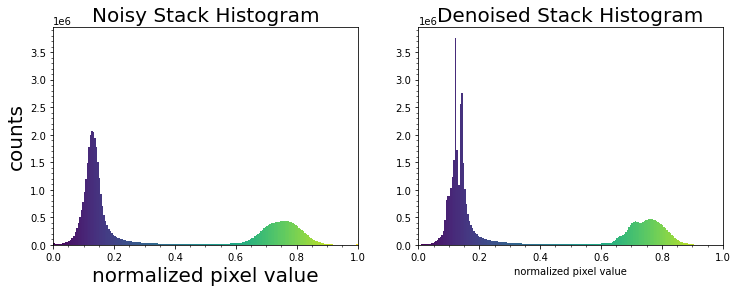

In [152]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

counts, bins, patches = ax[0].hist(stack_normal_1D, bins=bins,)
ax[0].set_title("Noisy Stack Histogram", fontsize=20)
ax[0].set_xlabel("normalized pixel value", fontsize=20)
ax[0].set_ylabel("counts", fontsize=20)
ax[0].minorticks_on()


counts2, bins2, patches2 = ax[1].hist(stack_nlm_1D, bins=bins,)

# make histograms colored by normalized pixel value
# first histogram
# get the value for the center of the bins
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# color the histogram by value
for c, p in zip(bin_centers, patches):
    plt.setp(p, "facecolor", colormap(c))

# second histogram
bin_centers2 = 0.5 * (bins[:-1] + bins[1:])

# color the histogram by value
for c, p in zip(bin_centers2, patches2):
    plt.setp(p, "facecolor", colormap(c))

ax[1].set_title("Denoised Stack Histogram", fontsize=20)
ax[1].set_xlabel("normalized pixel value")
ax[1].minorticks_on()
# ax[0].set_yscale('log')
# ax[1].set_yscale('log')
ax[0].set_ylim(0, np.max(1.05 * counts2))
ax[1].set_ylim(0, np.max(1.05 * counts2))
ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)

## Create elevation map for watershed markers

A brief blurb on the watershed algorithem from [Roerdink and Meijster, 2000](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.10.3852&rep=rep1&type=pdf):

"The watershed transform can be classified as a region-based segmentation approach. The intuitive idea underlying this method comes from geography: it is that of a landscape or topographic relief which is flooded by water, watersheds being the divide lines of the domains of attraction of rain falling over the region [46]. An alternative approach is to imagine the landscape being immersed in a lake, with holes pierced in local minima. Basins (also called ‘catchment basins’) will fill up with water starting at these local minima, and, at points where water coming from different basins would meet, dams are built. When the water level has reached the highest peak in the landscape, the process is stopped. As a result, the landscape is partitioned into regions or basins separated by dams, called watershed lines or simply watersheds."


Here we use the [sobel](https://scikit-image.org/docs/dev/auto_examples/edges/plot_edge_filter.html#sphx-glr-auto-examples-edges-plot-edge-filter-py) edge filter to make an "elevation map" as in this [example](https://scikit-image.org/docs/0.12.x/auto_examples/xx_applications/plot_coins_segmentation.html#region-based-segmentation) which represents the image gradient at each pixel. 

  0%|          | 0/195 [00:00<?, ?it/s]

(-0.5, 431.5, 496.5, -0.5)

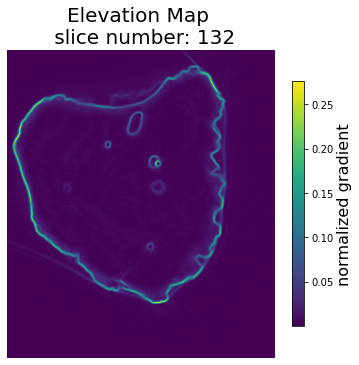

In [153]:
elevation_algorithm = "sobel"
elevation_map = ct.create_elevation_map(stack_nlm, method=elevation_algorithm)

# slice_number = 99
fig, ax = plt.subplots(figsize=(6, 6))

m = ax.imshow(elevation_map[slice_number], cmap=cmap)
ax.set_title("Elevation Map \n slice number: {}".format(slice_number), fontsize=20)

cbar = fig.colorbar(m, ax=ax, shrink=0.75,)
cbar.set_label(label="normalized gradient", fontsize=16)

ax.axis("off")

## Pick your markers for the segmentation

Although we apply the watershed algorithm to the elevation map created above, we first need to define our markers! Think of the algorithm starting at these markers and moving out (up) from there, classifying the image not just by pixel value, but it's topographical location relative to the pixels around it. Because this adds in a spatial component to the image segmentation, it often times produces more accurate results than simple thresholding. Based on the histogram above you will determine the number of segments for your image (i.e. background, sample holder, phase 1, phase 2, etc.). To set watershed markers, in brief, we create a new array that is the same shape as our stack, but fill it with 0s. We are then going to replace those 0s with 'marker' values for a certain pixel range.

In [164]:
#clasify the number of phases here and their normalized
#pixel limits. Note that for intermediate value phases
#you must specify a lower and upper limit
phase1_limit = [0.4]
phase2_limit = [0.45, 0.64]
phase3_limit = [0.65, 0.75]
phase4_limit = [0.77, 0.85]
phase5_limit = [0.9]

phase_limits = [phase1_limit, phase2_limit, phase3_limit, phase4_limit,phase5_limit]

markers = ct.add_markers(stack_nlm, phase_limits)

filling markers for phase: 1
pixel boundary: x < [0.4]


  0%|          | 0/195 [00:00<?, ?it/s]

filling markers for phase: 2
pixel boundary: 0.45 > x > 0.64


  0%|          | 0/195 [00:00<?, ?it/s]

filling markers for phase: 3
pixel boundary: 0.65 > x > 0.75


  0%|          | 0/195 [00:00<?, ?it/s]

filling markers for phase: 4
pixel boundary: 0.77 > x > 0.85


  0%|          | 0/195 [00:00<?, ?it/s]

filling markers for phase: 5
pixel boundary: x > [0.9]


  0%|          | 0/195 [00:00<?, ?it/s]

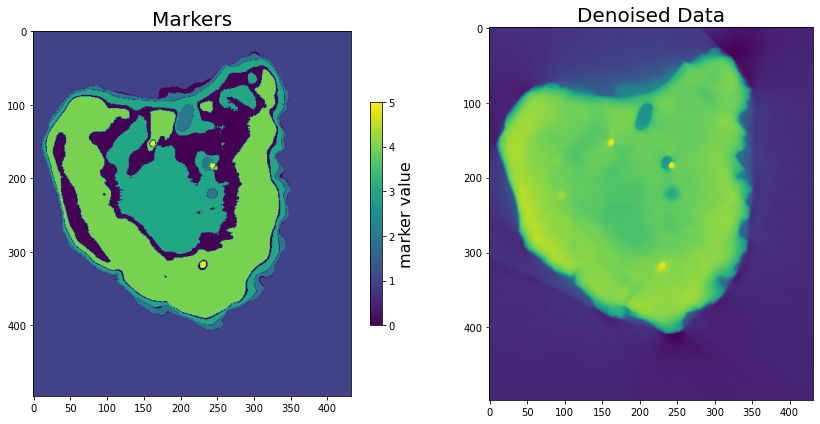

In [165]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
m = ax[0].imshow(markers[slice_number], cmap=cmap)
ax[0].set_title("Markers", fontsize=20)
bounds = np.linspace(0, 5, 6)

cbar = fig.colorbar(m, ax=ax[0], ticks=bounds, shrink=0.6,)
cbar.set_label(label="marker value", fontsize=16)
ax[1].imshow(stack_nlm[slice_number], cmap=cmap)
ax[1].set_title("Denoised Data", fontsize=20)

fig.tight_layout()

## Run the watershed segmentation

In [166]:
ws_results = ct.run_watershed_segmentation(elevation_map, markers)



  0%|          | 0/195 [00:00<?, ?it/s]

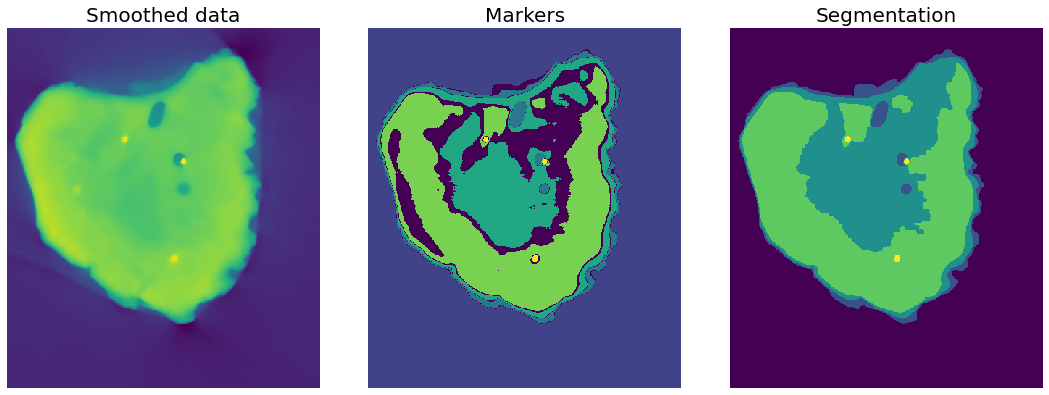

In [167]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(stack_nlm[slice_number], cmap=cmap, interpolation="nearest")
ax[0].axis("off")
ax[0].set_title("Smoothed data", fontsize=20)
ax[1].imshow(markers[slice_number], cmap=cmap, interpolation="nearest")
ax[1].axis("off")
ax[1].set_title("Markers", fontsize=20)
ax[2].imshow(ws_results[slice_number], cmap=cmap, interpolation="nearest")
ax[2].axis("off")
ax[2].set_title("Segmentation", fontsize=20)

fig.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)

## Save results and make a report of all requisite metadata
Here we'll save the data as a stack of .tif files that represent the segmented images. We also save the metadata (e.g., all the input decisions made in the pipeline) to be reproducible.


In [168]:
outpath = filepath

ct.save_seg_results(outpath, name, ws_results, cmap)
segmentation_metadata = {
        "name": name,
        "original_stack_shape": [original_stack_shape],
        "processed_stack_shape": [stack.shape],
        "rescaled_percentile_values": [[lower_lim, upper_lim]],
        "denoise_patch_size": patch_size,
        "denoise_patch_distance": patch_distance,
        "elevation_map_algorithm": elevation_algorithm,
    }
ct.save_metadata(segmentation_metadata,phase_limits,outpath, name)

  0%|          | 0/195 [00:00<?, ?it/s]

Your images have been saved to the following directory:
D:\Jorgenson_CT_work\0053_19CJ13_xL1\stacks
Your metadata has been saved as:
0053_19CJ13_xL1_segmentation_metadata.csv

in the following directory: 
D:\Jorgenson_CT_work\0053_19CJ13_xL1\stacks
